In [1]:
# !pip install -q ptflops

In [2]:
#!pip install -r requirements.txt

In [3]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import jaccard_score
import numpy as np
import math
import torch.nn.functional as F
import torchvision
import time
import pandas as pd
from PIL import Image
import datetime
import random
import sys

In [4]:
# # 기본 디렉토리 설정 
# TRAIN_DIR = "/kaggle/input/2025-sw-ai/archive/train"
# VAL_DIR = "/kaggle/input/2025-sw-ai/archive/val"
# TEST_DIR = "/kaggle/input/2025-sw-ai/archive/test/images"
# OUTPUT_PATH = "/kaggle/working/submission.csv"

In [5]:
# 로컬 디렉토리 설정
TRAIN_DIR = "input/2025-csu-sw-ai-challenge/archive/train" 
VAL_DIR = "input/2025-csu-sw-ai-challenge/archive/val"
TEST_DIR = "input/2025-csu-sw-ai-challenge/archive/test/images"
OUTPUT_CSV = "working/submission.csv" 
OUTPUT_MASK = "working/mask_ouputs"

In [6]:
SEED = 2025
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'set SEED: {SEED}')
set_seed()

set SEED: 2025


In [7]:
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate,
    RandomBrightnessContrast, RandomGamma, GaussNoise, OneOf, Blur, MotionBlur,
    CoarseDropout, GridDistortion, ElasticTransform, CLAHE
)
from albumentations.pytorch import ToTensorV2

def get_transform():
    return Compose([
        HorizontalFlip(p=0.5),                # 좌우 반전 50%
        VerticalFlip(p=0.3),                  # 상하 반전 30%
        RandomRotate90(p=0.3),                # 90도 회전 30%
        ShiftScaleRotate(
            shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.5
        ),                                   # 약간 줄인 회전 제한 (30->20도)
        OneOf([
            GaussNoise(var_limit=(5.0, 15.0), p=0.7),  # 노이즈 강도 줄임
            Blur(blur_limit=3, p=0.5),
            MotionBlur(blur_limit=3, p=0.5)
        ], p=0.4),
        OneOf([
            GridDistortion(num_steps=5, distort_limit=0.15, p=0.3),  # 왜곡 제한 감소
            ElasticTransform(alpha=1, sigma=30, alpha_affine=20, p=0.2)  # 탄성 변환 약하게
        ], p=0.3),
        CoarseDropout(num_holes=6, max_h_size=10, max_w_size=10, fill_value=0, p=0.3),
        CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.25),             # 확률 소폭감소
        RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.3),
        RandomGamma(gamma_limit=(85, 115), p=0.3),                        # 감마 범위 좁힘
        ToTensorV2()
    ])


class CrackDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment_ratio=1):
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.img_list = sorted(glob.glob(self.img_dir + "/*.jpg"))
        self.mask_list = sorted(glob.glob(self.mask_dir + "/*.jpg"))
        self.transform = transform
        self.augment_ratio = max(1, augment_ratio)  # 최소 1 이상

    def __len__(self):
        # 원본 + (augment_ratio-1) 증강본 총합
        return len(self.img_list) * self.augment_ratio

    def __getitem__(self, idx):
        original_count = len(self.img_list)

        if idx < original_count:
            # 원본 이미지를 그대로 반환
            img = Image.open(self.img_list[idx]).convert("L")
            mask = Image.open(self.mask_list[idx]).convert("L")

            img = np.array(img, dtype=np.float32) / 255.0
            mask = np.array(mask, dtype=np.float32) / 255.0
            mask = (mask > 0.5).astype(np.float32)

            img = torch.tensor(img).unsqueeze(0)
            mask = torch.tensor(mask).unsqueeze(0)

            return img, mask

        else:
            # 증강 이미지 인덱스 변환 및 증강 적용
            aug_idx = idx - original_count
            orig_idx = aug_idx % original_count

            img = Image.open(self.img_list[orig_idx]).convert("L")
            mask = Image.open(self.mask_list[orig_idx]).convert("L")

            img = np.array(img, dtype=np.float32) / 255.0
            mask = np.array(mask, dtype=np.float32) / 255.0
            mask = (mask > 0.5).astype(np.float32)

            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask'].unsqueeze(0).float()
            else:
                img = torch.tensor(img).unsqueeze(0)
                mask = torch.tensor(mask).unsqueeze(0)

            return img, mask

/home/jms/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
class HrSegNetB16(nn.Module):
    def __init__(self,
                 in_channels=1,  # input channel
                 base=16,  # base channel of the model, 
                 num_classes=1,  # number of classes
                 pretrained=None  # pretrained model
                 ):
        super(HrSegNetB16, self).__init__()
        self.base = base
        self.num_classes = num_classes
        self.pretrained = pretrained
        # Stage 1 and 2 constitute the stem of the model, which is mainly used to extract low-level features.
        # Meanwhile, stage1 and 2 reduce the input image to 1/2 and 1/4 of the original size respectively
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=base // 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base // 2),
            nn.ReLU(),
        )
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=base // 2, out_channels=base, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU(),
        )
        
        self.seg1 = SegBlock(base=base, stage_index=1)
        self.seg2 = SegBlock(base=base, stage_index=2)
        self.seg3 = SegBlock(base=base, stage_index=3)

        self.aux_head1 = SegHead(inplanes=base, interplanes=base, outplanes=num_classes, aux_head=True)
        self.aux_head2 = SegHead(inplanes=base, interplanes=base, outplanes=num_classes, aux_head=True)
        self.head = SegHead(inplanes=base, interplanes=base, outplanes=num_classes)

        self.init_weight()
    
    def forward(self, x):
        logit_list = []
        h, w = x.shape[2:]
        # aux_head only used in training
        if self.training:
            stem1_out = self.stage1(x)
            stem2_out = self.stage2(stem1_out)
            hrseg1_out = self.seg1(stem2_out)
            hrseg2_out = self.seg2(hrseg1_out)
            hrseg3_out = self.seg3(hrseg2_out)
            last_out = self.head(hrseg3_out)
            seghead1_out = self.aux_head1(hrseg1_out)
            seghead2_out = self.aux_head2(hrseg2_out)
            logit_list = [last_out, seghead1_out, seghead2_out]
            logit_list = [F.interpolate(logit, size=(h, w), mode='bilinear', align_corners=True) for logit in logit_list]
            return logit_list
        else:
            stem1_out = self.stage1(x)
            stem2_out = self.stage2(stem1_out)
            hrseg1_out = self.seg1(stem2_out)
            hrseg2_out = self.seg2(hrseg1_out)
            hrseg3_out = self.seg3(hrseg2_out)
            last_out = self.head(hrseg3_out)
            logit_list = [last_out]
            logit_list = [F.interpolate(logit, size=(h, w), mode='bilinear', align_corners=True) for logit in logit_list]
            return logit_list
        
    
    def init_weight(self):
        if self.pretrained is not None:
            pass
        else:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
    
class SegBlock(nn.Module):
    def __init__(self, base=32, stage_index=1):
        super(SegBlock, self).__init__()

        # Convolutional layer for high-resolution paths with constant spatial resolution and constant channel
        self.h_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=base, out_channels=base, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU()
        )
        self.h_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=base, out_channels=base, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU()
        )
        self.h_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=base, out_channels=base, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU()
        )

        # Semantic guidance path/low-resolution path
        if stage_index == 1:  # First stage, stride=2, spatial resolution/2, channel*2
            self.l_conv1 = nn.Sequential(
                nn.Conv2d(in_channels=base, out_channels=base * int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base * int(math.pow(2, stage_index))),
                nn.ReLU()
            )
        elif stage_index == 2:  # Second stage
            self.l_conv1 = nn.Sequential(
                nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                nn.Conv2d(in_channels=base, out_channels=base * int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base * int(math.pow(2, stage_index))),
                nn.ReLU()
            )
        elif stage_index == 3:
            self.l_conv1 = nn.Sequential(
                nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                nn.Conv2d(in_channels=base, out_channels=base * int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base * int(math.pow(2, stage_index))),
                nn.ReLU(),
                nn.Conv2d(in_channels=base * int(math.pow(2, stage_index)), out_channels=base * int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base * int(math.pow(2, stage_index))),
                nn.ReLU()
            )
        else:
            raise ValueError("stage_index must be 1, 2 or 3")
        self.l_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=base * int(math.pow(2, stage_index)), out_channels=base * int(math.pow(2, stage_index)), kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base * int(math.pow(2, stage_index))),
            nn.ReLU()
        )
        self.l_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=base * int(math.pow(2, stage_index)), out_channels=base * int(math.pow(2, stage_index)), kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base * int(math.pow(2, stage_index))),
            nn.ReLU()
        )

        self.l2h_conv1 = nn.Conv2d(in_channels=base * int(math.pow(2, stage_index)), out_channels=base, kernel_size=1, stride=1, padding=0)
        self.l2h_conv2 = nn.Conv2d(in_channels=base * int(math.pow(2, stage_index)), out_channels=base, kernel_size=1, stride=1, padding=0)
        self.l2h_conv3 = nn.Conv2d(in_channels=base * int(math.pow(2, stage_index)), out_channels=base, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        size = x.shape[2:]
        out_h1 = self.h_conv1(x)  # high resolution path
        out_l1 = self.l_conv1(x)  # low resolution path
        out_l1_i = F.interpolate(out_l1, size=size, mode='bilinear', align_corners=True)  # upsample
        out_hl1 = self.l2h_conv1(out_l1_i) + out_h1  # low to high

        out_h2 = self.h_conv2(out_hl1)
        out_l2 = self.l_conv2(out_l1)
        out_l2_i = F.interpolate(out_l2, size=size, mode='bilinear', align_corners=True)
        out_hl2 = self.l2h_conv2(out_l2_i) + out_h2

        out_h3 = self.h_conv3(out_hl2)
        out_l3 = self.l_conv3(out_l2)
        out_l3_i = F.interpolate(out_l3, size=size, mode='bilinear', align_corners=True)
        out_hl3 = self.l2h_conv3(out_l3_i) + out_h3
        return out_hl3

# seg head
class SegHead(nn.Module):
    def __init__(self, inplanes, interplanes, outplanes, aux_head=False):
        super(SegHead, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU()
        if aux_head:
            self.con_bn_relu = nn.Sequential(
                nn.Conv2d(in_channels=inplanes, out_channels=interplanes, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(interplanes),
                nn.ReLU(),
            )
        else:
            self.con_bn_relu = nn.Sequential(
                nn.ConvTranspose2d(in_channels=inplanes, out_channels=interplanes, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(interplanes),
                nn.ReLU(),
            )
        self.conv = nn.Conv2d(in_channels=interplanes, out_channels=outplanes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.bn1(x)
        x = self.relu(x)
        x = self.con_bn_relu(x)
        out = self.conv(x)
        return out

In [9]:
def binary_metrics(preds, targets, eps=1e-6):
    preds = preds.float()
    targets = targets.float()

    tp = (preds * targets).sum(dim=(1,2,3))
    fp = (preds * (1 - targets)).sum(dim=(1,2,3))
    fn = ((1 - preds) * targets).sum(dim=(1,2,3))

    precision = (tp + eps) / (tp + fp + eps)
    recall    = (tp + eps) / (tp + fn + eps)
    f1        = (2 * precision * recall + eps) / (precision + recall + eps)  # Dice
    union     = tp + fp + fn
    iou       = (tp + eps) / (union + eps)

    return {
        "iou": iou.mean().item(),
        "precision": precision.mean().item(),
        "recall": recall.mean().item(),
        "f1": f1.mean().item(),
    }

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time

# --- [추가] F-beta 손실 함수 정의 ---
class FbetaLoss(nn.Module):
    def __init__(self, beta=2.0, smooth=1e-6):
        super(FbetaLoss, self).__init__()
        self.beta = beta
        self.smooth = smooth

    def forward(self, logits, targets):
        preds = torch.sigmoid(logits)

        tp = (preds * targets).sum(dim=(2, 3))
        fp = (preds * (1 - targets)).sum(dim=(2, 3))
        fn = ((1 - preds) * targets).sum(dim=(2, 3))

        beta2 = self.beta ** 2
        f_beta = ((1 + beta2) * tp + self.smooth) / ((1 + beta2) * tp + beta2 * fn + fp + self.smooth)
        
        return 1 - f_beta.mean()

# --- [추가] F-beta 점수 계산 함수 (검증용) ---
def calculate_fbeta(preds, masks, beta=2.0, smooth=1e-6):
    preds = preds.float()
    masks = masks.float()

    # 배치 전체를 하나의 큰 이미지로 보고 계산
    tp = (preds * masks).sum()
    fp = (preds * (1 - masks)).sum()
    fn = ((1 - preds) * masks).sum()
    
    beta2 = beta ** 2
    f_beta = ((1 + beta2) * tp + smooth) / ((1 + beta2) * tp + beta2 * fn + fp + smooth)
    
    return f_beta.item()

# --- [적용] 사용자께서 제공하신 binary_metrics 함수 ---
def binary_metrics(preds, targets, eps=1e-6):
    preds = preds.float()
    targets = targets.float()

    # 배치 내 각 샘플에 대해 TP, FP, FN 계산
    tp = (preds * targets).sum(dim=(1,2,3))
    fp = (preds * (1 - targets)).sum(dim=(1,2,3))
    fn = ((1 - preds) * targets).sum(dim=(1,2,3))

    precision = (tp + eps) / (tp + fp + eps)
    recall    = (tp + eps) / (tp + fn + eps)
    f1        = (2 * precision * recall + eps) / (precision + recall + eps)
    union     = tp + fp + fn
    iou       = (tp + eps) / (union + eps)

    # 각 지표를 배치에 대해 평균내어 반환
    return {
        "iou": iou.mean().item(),
        "precision": precision.mean().item(),
        "recall": recall.mean().item(),
        "f1": f1.mean().item(),
    }

# ------------------------------------------------------------------
# train_model 함수
# ------------------------------------------------------------------

def train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=10,
    aux_weights=(1.0, 0.4, 0.4),
    lr=1e-3,
    use_amp=False,
    log_every=500,
    validate_every_steps=None,
    threshold=0.5,
    patience=5,
    model_save_path='best_model.pth'
):
    model.to(device)
    criterion = FbetaLoss(beta=2.0)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # --- [추가] Early Stopping을 위한 변수 초기화 ---
    patience_counter = 0
    best_val_fbeta = 0.0

    global_step = 0
    # --- [복원] Step 단위 로깅을 위한 변수 ---
    win_loss, win_iou, win_f1, win_steps = 0.0, 0.0, 0.0, 0
    t0 = time.time()

    best_threshold = threshold  # F2 score 최적화 위해 threshold 저장 변수 추가

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0

        for imgs, masks in train_loader:
            global_step += 1
            imgs = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(imgs)
                main_logit = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
                
                loss = aux_weights[0] * criterion(main_logit, masks)
                if isinstance(outputs, (list, tuple)):
                    if len(outputs) > 1 and aux_weights[1] > 0:
                        loss = loss + aux_weights[1] * criterion(outputs[1], masks)
                    if len(outputs) > 2 and aux_weights[2] > 0:
                        loss = loss + aux_weights[2] * criterion(outputs[2], masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
            
            # --- [복원] Step 단위 로깅을 위한 집계 로직 ---
            win_loss += loss.item()
            win_steps += 1
            with torch.no_grad():
                probs = torch.sigmoid(main_logit)
                preds = (probs > best_threshold).float()
                m = binary_metrics(preds, masks)
                win_iou += m["iou"]
                win_f1  += m["f1"]
            
            # --- [복원] Step 단위 로깅 출력문 ---
            if log_every and (global_step % log_every == 0):
                elapsed = time.time() - t0
                lr_now = optimizer.param_groups[0]["lr"]
                print(f"[Step {global_step}] epoch={epoch}  "
                      f"avg_loss(win)={win_loss/max(1,win_steps):.4f}  "
                      f"avg_iou(win)={win_iou/max(1,win_steps):.4f}  "
                      f"avg_f1(win)={win_f1/max(1,win_steps):.4f}  "
                      f"lr={lr_now:.3e}  elapsed={elapsed:.1f}s")
                win_loss = win_iou = win_f1 = 0.0
                win_steps = 0
                t0 = time.time()

        # --- Epoch 종료 후 검증 ---
        avg_train_loss = epoch_loss / max(1, len(train_loader))
        model.eval()

        val_fbeta_list, val_loss_list, val_iou_list, val_f1_list = [], [], [], []

        all_probs = []
        all_masks = []

        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)

                logits_list = model(imgs)
                main_logit = logits_list[0] if isinstance(logits_list, (list, tuple)) else logits_list

                loss = criterion(main_logit, masks)
                val_loss_list.append(loss.item())

                probs = torch.sigmoid(main_logit)
                all_probs.append(probs.cpu())
                all_masks.append(masks.cpu())

                preds = (probs > best_threshold).float()

                fbeta_score = calculate_fbeta(preds, masks, beta=2.0)
                val_fbeta_list.append(fbeta_score)

                m = binary_metrics(preds, masks)
                val_iou_list.append(m["iou"])
                val_f1_list.append(m["f1"])

        all_probs = torch.cat(all_probs, dim=0).numpy()
        all_masks = torch.cat(all_masks, dim=0).numpy()

        # --- Threshold 최적화 (F2 score 기준) ---
        thresholds = np.linspace(0.0, 0.99, 200)
        best_score = 0.0
        best_epoch_threshold = best_threshold

        for t in thresholds:
            preds_bin = (all_probs > t).astype(np.uint8)
            tp = (preds_bin * all_masks).sum(axis=(1,2,3))
            fp = (preds_bin * (1 - all_masks)).sum(axis=(1,2,3))
            fn = ((1 - preds_bin) * all_masks).sum(axis=(1,2,3))

            beta2 = 2.0 ** 2
            f_beta = ((1 + beta2) * tp + 1e-6) / ((1 + beta2) * tp + beta2 * fn + fp + 1e-6)
            score = f_beta.mean()

            if score > best_score:
                best_score = score
                best_epoch_threshold = t
        # --- Threshold 최적화 끝 ---

        avg_val_loss = np.mean(val_loss_list)
        avg_val_fbeta = np.mean(val_fbeta_list)
        avg_val_iou = np.mean(val_iou_list)
        avg_val_f1 = np.mean(val_f1_list)

        # --- [복원] Epoch 단위 출력문에 F2 score, 최적 threshold 출력 추가 ---
        print(f"[Epoch {epoch}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val IoU: {avg_val_iou:.4f} | "
              f"Val F1: {avg_val_f1:.4f} | "
              f"Val F-beta(β=2.0): {avg_val_fbeta:.4f} | "
              f"Best Threshold: {best_epoch_threshold:.3f} | "
              f"Best F-beta@threshold: {best_score:.4f}")

        # Early Stopping 로직 (F-beta 기준)
        if best_score > best_val_fbeta:
            best_val_fbeta = best_score
            best_threshold = best_epoch_threshold
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f" -> Best score updated. Model saved.")
        else:
            patience_counter += 1
            print(f" -> Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement.")
            break
            
    print(f"\nTraining finished. Best Val F-beta(β=2.0) was: {best_val_fbeta:.4f}")
    print(f"Best Threshold found: {best_threshold:.3f}")

    model.load_state_dict(torch.load(model_save_path))
    return model, best_threshold


In [11]:
train_dataset = CrackDataset(TRAIN_DIR, transform=get_transform(), augment_ratio=3)
val_dataset = CrackDataset(VAL_DIR, transform=None, augment_ratio=1)

print("Load..tarin data")
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
print("Loaded train data")
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Load..tarin data
Loaded train data


/home/jms/.local/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_1259/1162808618.py:17: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  GaussNoise(var_limit=(5.0, 15.0), p=0.7),  # 노이즈 강도 줄임
/tmp/ipykernel_1259/1162808618.py:23: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  ElasticTransform(alpha=1, sigma=30, alpha_affine=20, p=0.2)  # 탄성 변환 약하게
/tmp/ipykernel_1259/1162808618.py:25: UserWarning: Argument(s) 'num_holes, max_h_size, max_w_size, fill_value' are not valid for transform CoarseDropout
  CoarseDropout(num_holes=6, max_h_size=10, max_w_size=10, fill_value=0, p=0.3),


In [12]:
from ptflops import get_model_complexity_info

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HrSegNetB16().to(device)
input_size = (1, 192, 192)

macs, params = get_model_complexity_info(model,
                                         input_size,
                                         as_strings=True,
                                         print_per_layer_stat=False,
                                         verbose=False)
print(f"Total Params: {params}")
print(f"Total MACs: {macs}")

Total Params: 609.75 k
Total MACs: 130.86 MMac


In [13]:
print(device)
model, best_threshold = train_model(model, train_loader, val_loader, device, epochs=100, patience=12)

cuda


/tmp/ipykernel_1259/1287974975.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_1259/1287974975.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[Step 500] epoch=1  avg_loss(win)=1.3743  avg_iou(win)=0.1050  avg_f1(win)=0.1806  lr=1.000e-03  elapsed=25.0s
[Step 1000] epoch=1  avg_loss(win)=1.1708  avg_iou(win)=0.1931  avg_f1(win)=0.3044  lr=1.000e-03  elapsed=20.9s
[Step 1500] epoch=1  avg_loss(win)=1.0997  avg_iou(win)=0.2269  avg_f1(win)=0.3487  lr=1.000e-03  elapsed=21.9s
[Step 2000] epoch=1  avg_loss(win)=1.0604  avg_iou(win)=0.2477  avg_f1(win)=0.3729  lr=1.000e-03  elapsed=21.4s
[Step 2500] epoch=1  avg_loss(win)=1.0285  avg_iou(win)=0.2594  avg_f1(win)=0.3848  lr=1.000e-03  elapsed=19.3s
[Epoch 1/100] Train Loss: 1.1323 | Val Loss: 0.4929 | Val IoU: 0.3327 | Val F1: 0.4645 | Val F-beta(β=2.0): 0.6377 | Best Threshold: 0.950 | Best F-beta@threshold: 0.5330
 -> Best score updated. Model saved.
[Step 3000] epoch=2  avg_loss(win)=1.0232  avg_iou(win)=0.2676  avg_f1(win)=0.3993  lr=1.000e-03  elapsed=61.0s
[Step 3500] epoch=2  avg_loss(win)=1.0206  avg_iou(win)=0.2734  avg_f1(win)=0.4078  lr=1.000e-03  elapsed=21.1s
[Step 400

In [14]:
def save_mask_image(
    mask_image: Image.Image,
    base_output_dir: str,
    original_filename: str,
    script_name: str = 'defalut'
):
    """
    마스크 이미지를 지정된 규칙에 따라 폴더를 생성하고 저장합니다.

    Args:
        mask_image (Image.Image): 저장할 PIL 이미지 객체.
        base_output_dir (str): 결과 폴더를 생성할 상위 경로.
        original_filename (str): 원본 이미지 파일명 (e.g., 'image_001.jpg').
        script_name (str): 현재 실행 중인 파이썬 스크립트 또는 노트북 파일명.
    
    Returns:
        str: 파일이 저장된 전체 경로.
    """
    # 1. 'test_파일명_mmddhhmm' 형식으로 폴더명 생성
    now = datetime.datetime.now()
    timestamp = now.strftime("%m%d%H%M")  # mmddhhmm 형식
    
    # 스크립트 이름에서 확장자(.py, .ipynb) 제거
    script_basename = os.path.splitext(script_name)[0]
    
    folder_name = f"test_{script_basename}_{timestamp}"
    output_dir = os.path.join(base_output_dir, folder_name)
    
    # 폴더 생성 (이미 존재하면 그대로 사용)
    os.makedirs(output_dir, exist_ok=True)

    # 2. 저장할 파일명 생성 (원본 파일명 기반)
    original_basename = os.path.splitext(original_filename)[0]
    output_filename = f"{original_basename}_mask.png"
    
    # 3. 전체 저장 경로를 조합하고 이미지 저장
    output_path = os.path.join(output_dir, output_filename)
    mask_image.save(output_path)
    
    return output_path

In [15]:
def rle_encode(mask):
    """
    mask: 2D numpy array of {0,1}, shape (H,W)
    return: run length as string
    """
    pixels = mask.flatten(order="C")
    ones = np.where(pixels == 1)[0] + 1  # 1-based
    if len(ones) == 0:
        return ""
    runs = []
    prev = -2
    for idx in ones:
        if idx > prev + 1:
            runs.extend((idx, 0))
        runs[-1] += 1
        prev = idx
    return " ".join(map(str, runs))


def predict_and_submit(model, test_img_dir, output_csv, device, threshold=0.5):
    model.eval()
    ids, rles = [], []

    test_imgs = sorted(glob.glob(os.path.join(test_img_dir, "*.jpg")))
    for path in test_imgs:
        img_id = os.path.splitext(os.path.basename(path))[0]
        img = Image.open(path).convert("L")
        arr = np.array(img, dtype=np.float32) / 255.0
        tensor = torch.tensor(arr).unsqueeze(0).unsqueeze(0).to(device)

        with torch.no_grad():
            out_list = model(tensor)
            main_logit = out_list[0] if isinstance(out_list, (list, tuple)) else out_list
            prob = torch.sigmoid(main_logit)[0,0].cpu().numpy()
            pred = (prob > threshold).astype(np.uint8)
        
        rle = rle_encode(pred)
        ids.append(img_id)
        rles.append(rle)

    df = pd.DataFrame({"image_id": ids, "rle": rles})
    df.to_csv(output_csv, index=False)
    print(f"[OK] submission saved to {output_csv}, total {len(df)} rows.")

In [16]:

def rle_encode(mask):
    """
    mask: 2D numpy array of {0,1}, shape (H,W)
    return: run length as string
    """
    pixels = mask.flatten(order="C")
    ones = np.where(pixels == 1)[0] + 1  # 1-based
    if len(ones) == 0:
        return ""
    runs = []
    prev = -2
    for idx in ones:
        if idx > prev + 1:
            runs.extend((idx, 0))
        runs[-1] += 1
        prev = idx
    return " ".join(map(str, runs))


def predict_submit_and_save_masks(
    model, 
    test_img_dir, 
    output_csv, 
    device, 
    threshold=0.5,
    save_masks=False,
    mask_save_dir=None
):
    model.to(device)
    model.eval()
    ids, rles = [], []

    # --- 이미지 저장을 위한 폴더 설정 ---
    output_mask_path = ""
    if save_masks:
        if mask_save_dir is None:
            # mask_save_dir가 지정되지 않으면 에러 발생
            raise ValueError("If save_masks is True, mask_save_dir must be provided.")
        
        # 현재 시간을 기반으로 하위 폴더 생성
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        output_mask_path = os.path.join(mask_save_dir, f"predictions_{timestamp}")
        os.makedirs(output_mask_path, exist_ok=True)
        print(f"Mask images will be saved to: {output_mask_path}")

    test_imgs = sorted(glob.glob(os.path.join(test_img_dir, "*.jpg")))
    for path in test_imgs:
        img_id = os.path.splitext(os.path.basename(path))[0]
        img = Image.open(path).convert("L")
        arr = np.array(img, dtype=np.float32) / 255.0
        tensor = torch.tensor(arr).unsqueeze(0).unsqueeze(0).to(device)

        with torch.no_grad():
            out_list = model(tensor)
            main_logit = out_list[0] if isinstance(out_list, (list, tuple)) else out_list
            prob = torch.sigmoid(main_logit)[0,0].cpu().numpy()
            pred = (prob > threshold).astype(np.uint8)
        
        # ---  마스크 이미지를 파일로 저장 ---
        if save_masks:
            mask_image = Image.fromarray(pred * 255, mode='L')
            mask_filename = f"{img_id}_mask.png"
            save_path = os.path.join(output_mask_path, mask_filename)
            mask_image.save(save_path)

        # --- RLE 인코딩 및 CSV 데이터 수집 ---
        rle = rle_encode(pred)
        ids.append(img_id)
        rles.append(rle)

    # --- CSV 파일로 최종 저장 ---
    df = pd.DataFrame({"image_id": ids, "rle": rles})
    df.to_csv(output_csv, index=False)
    print(f"OK. Submission CSV saved to {output_csv}, total {len(df)} rows.")
    
    if save_masks:
        print(f"OK. Mask images also saved in: {output_mask_path}")

In [17]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def _to_numpy01(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().float()
        if x.ndim == 3 and x.shape[0] in (1,3):  # (C,H,W) -> (H,W)
            x = x[0]
        elif x.ndim == 4:  # (B,1,H,W) -> first item
            x = x[0,0]
        elif x.ndim == 2:
            pass
        else:
            raise ValueError(f"Unexpected tensor shape: {tuple(x.shape)}")
        x = x.numpy()
    else:
        x = np.array(x)
        if x.ndim == 3 and x.shape[0] in (1,3):
            x = x[0]
        elif x.ndim != 2:
            raise ValueError(f"Unexpected array shape: {tuple(x.shape)}")
    # normalize to [0,1]
    x = x.astype(np.float32)
    if x.max() > 1.0:
        x = x / 255.0
    x = np.clip(x, 0.0, 1.0)
    return x

def overlay_red_blue(gray01, gt01, pred01, alpha=0.45):
    H, W = gray01.shape
    base = np.stack([gray01, gray01, gray01], axis=-1)  # to RGB [0,1]

    # color layers
    red  = np.zeros_like(base); red[...,0] = 1.0               # (1,0,0)
    blue = np.zeros_like(base); blue[...,2] = 1.0              # (0,0,1)

    out = base.copy()
    # apply GT (red)
    gt_mask = gt01.astype(bool)
    out[gt_mask] = (1 - alpha) * out[gt_mask] + alpha * red[gt_mask]
    # apply Pred (blue)
    pred_mask = pred01.astype(bool)
    out[pred_mask] = (1 - alpha) * out[pred_mask] + alpha * blue[pred_mask]

    # convert to uint8
    out = (np.clip(out, 0, 1) * 255).astype(np.uint8)
    return out

@torch.no_grad()
def visualize_batch(model, loader, device="cuda", n=8, thresh=0.5, save_dir=None, title_prefix="Train"):
    model.eval()
    device = torch.device(device if torch.cuda.is_available() and device=="cuda" else "cpu")
    model.to(device)

    batch = next(iter(loader))
    if isinstance(batch, (list, tuple)) and len(batch) >= 2:
        imgs, gts = batch[0], batch[1]
        img_paths = None
    elif isinstance(batch, dict):
        imgs, gts = batch["image"], batch["mask"]
        img_paths = batch.get("path", None)
    else:
        raise ValueError("Loader batch format not understood. Expecting (images, masks).")

    imgs = imgs.to(device)  # (B,1,H,W) or (B,H,W)
    # forward
    preds = model(imgs)
    # make sure shape is (B,1,H,W)


    if isinstance(preds, dict):
        for k in ["out", "logits", "pred", "preds"]:
            if k in preds and isinstance(preds[k], torch.Tensor):
                preds = preds[k]
                break
        else:
            preds = next(v for v in preds.values() if isinstance(v, torch.Tensor))
    
    elif isinstance(preds, (list, tuple)):
        for v in reversed(preds):
            if isinstance(v, torch.Tensor):
                preds = v
                break
        else:
            raise ValueError("No tensor found in model outputs list/tuple.")
    
    if not isinstance(preds, torch.Tensor):
        raise TypeError(f"Model output must be a Tensor, got {type(preds)}")


    
    if preds.ndim == 3:  # (B,H,W) -> (B,1,H,W)
        preds = preds.unsqueeze(1)
    if preds.shape[1] != 1:
        if preds.shape[1] > 1:
            preds = torch.softmax(preds, dim=1)[:, 1:2, ...]
        else:
            pass
    # sigmoid for logits
    if preds.min() < 0 or preds.max() > 1:
        preds = torch.sigmoid(preds)

    B = imgs.shape[0]
    n = min(n, B)

    # figure
    cols = min(4, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(4*cols, 4*rows))

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for i in range(n):
        # tensors to numpy
        img_i  = _to_numpy01(imgs[i, ...])
        if img_i.ndim == 3:  # (C,H,W) -> (H,W)
            img_i = img_i[0]

        gt_i   = _to_numpy01(gts[i, ...])
        pred_i = _to_numpy01(preds[i, ...])

        # binarize masks
        gt_bin   = (gt_i >= 0.5).astype(np.uint8)
        pred_bin = (pred_i >= thresh).astype(np.uint8)

        vis = overlay_red_blue(img_i, gt_bin, pred_bin, alpha=0.45)

        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(vis)
        ax.set_axis_off()
        ax.set_title(f"{title_prefix} #{i} (thr={thresh:.2f})")

        if save_dir:
            fn = f"{title_prefix.lower()}_{i:02d}.png"
            plt.imsave(os.path.join(save_dir, fn), vis)

    plt.tight_layout()
    plt.show()

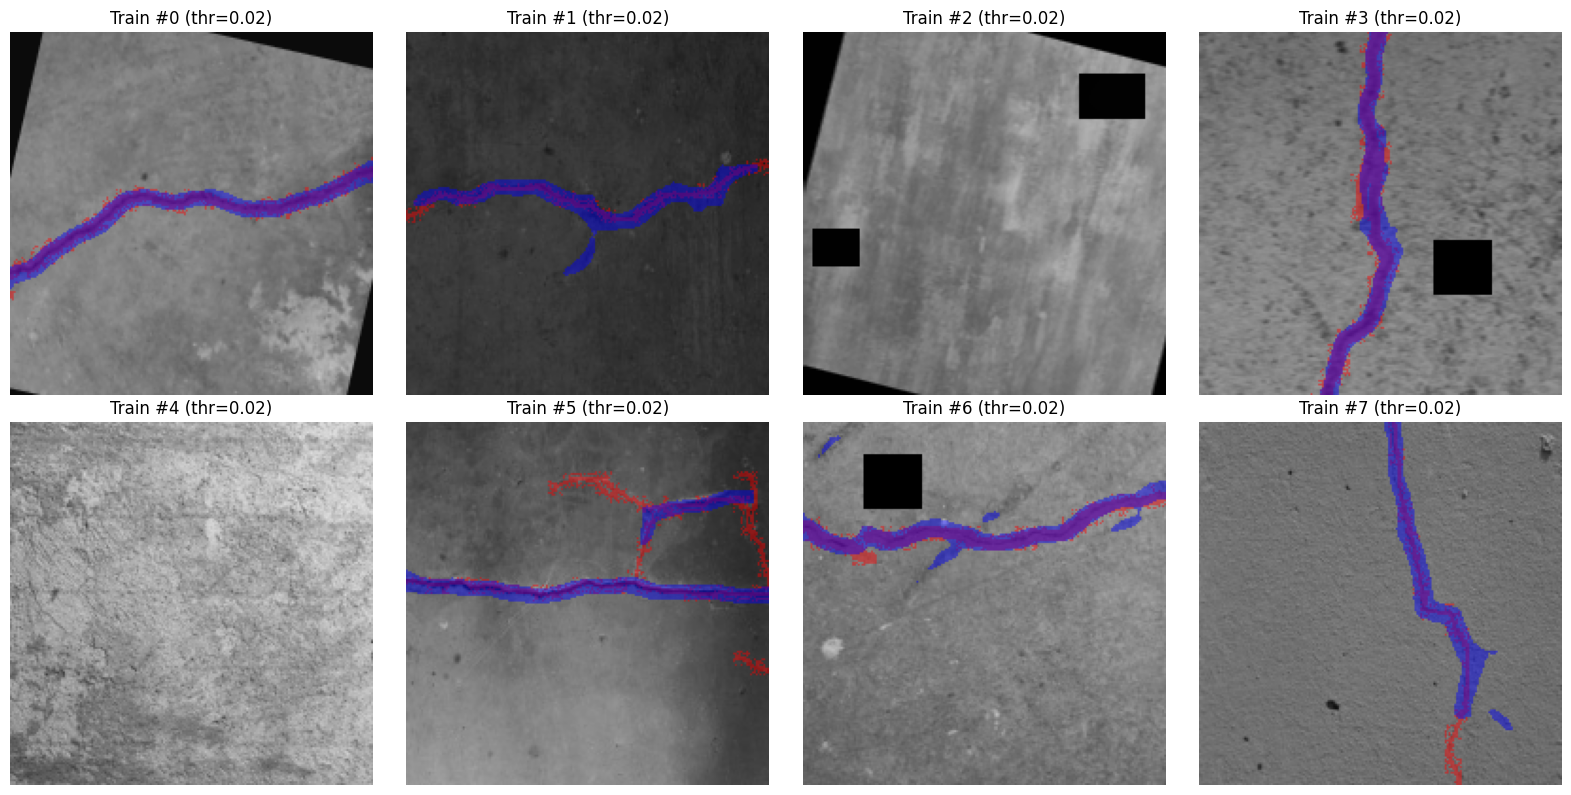

In [18]:
visualize_batch(model, train_loader, device=device, n=8, thresh=0.02, save_dir=None, title_prefix="Train")

In [19]:
predict_submit_and_save_masks(
    model=model,
    test_img_dir=TEST_DIR,
    output_csv="working/submission.csv",
    device=device,
    save_masks=True,  
    mask_save_dir=OUTPUT_MASK,
    threshold = best_threshold,
)

Mask images will be saved to: working/mask_ouputs/predictions_20251018_012847


/tmp/ipykernel_1259/1932092601.py:61: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_image = Image.fromarray(pred * 255, mode='L')


OK. Submission CSV saved to working/submission.csv, total 2667 rows.
OK. Mask images also saved in: working/mask_ouputs/predictions_20251018_012847
